# In search of an $\alpha$

##### Using 2D filtering for SST' and HFX' filtered parameters
##### Finding correlations

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
def SMfield(var,g_sigma=None,time_str='dayofyear'):
    from scipy.ndimage import gaussian_filter as gauss
    var_smoothed=var.copy()
    
    for ix in range(var[time_str].shape[0]):
        var_smoothed[ix]=gauss(var[ix].data,g_sigma)
    
    var_prime=var-var_smoothed
    return var_smoothed,var_prime

In [3]:
def tophat_bandpass_2d(data,lowcut=40,highcut=1):
    from scipy.signal import convolve2d
    BandFilt=data.copy()
    LowFilt=data.copy()


    
    for idd in range(data.shape[0]):
        lowcut= int(np.round(lowcut))

        y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
        disklow = x**2+y**2 <= lowcut**2
        disklow = disklow.astype(float)
        disklow = disklow/sum(sum(disklow))
        # DiskLow = xr.DataArray(disklow, dims=['kx', 'ky']) 
        
        # convolute the fields with the kernel
        lowfiltered = convolve2d(data[idd],disklow, mode='same', boundary='fill', fillvalue=0)
        
        # LowFilt=data.copy()
        # LowFilt[idd].data=lowfiltered
        # LowPrime=data[idd]-LowFilt
        lowprime=data[idd]-lowfiltered
        LowFilt[idd]=lowfiltered
        
        highcut= int(np.round(highcut))

        y,x = np.ogrid[-highcut: highcut+1, -highcut: highcut+1]
        diskhigh = x**2+y**2 <= highcut**2
        diskhigh = diskhigh.astype(float)
        diskhigh = diskhigh/sum(sum(diskhigh))

        # convolute the fields with the kernel
        # bandfiltered = convolve2d(LowPrime,diskhigh, mode='same', boundary='fill', fillvalue=0)
        bandfiltered = convolve2d(lowprime,diskhigh, mode='same', boundary='fill', fillvalue=0)

        # BandFilt=data.copy()
        BandFilt[idd]=bandfiltered
        
        
    return BandFilt,LowFilt

In [4]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [6]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [7]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listf_out=glob(path+'*out*');listf_out.sort()
varfout=xr.open_mfdataset(listf_out[-7:])

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'*out*');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[-7:])

In [8]:
varfout

<xarray.Dataset>
Dimensions:               (y_grid_U: 390, x_grid_U: 301, lev_M: 49, y_grid_V: 391, x_grid_V: 300, y_grid_M: 390, x_grid_M: 300, lev_W: 50, time_counter: 213, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_U        (y_grid_U, x_grid_U) float32 dask.array<chunksize=(390, 301), meta=np.ndarray>
    nav_lon_grid_U        (y_grid_U, x_grid_U) float32 dask.array<chunksize=(390, 301), meta=np.ndarray>
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
    nav_lat_grid_V        (y_grid_V, x_grid_V) float32 dask.array<chunksize=(391, 300), meta=np.ndarray>
    nav_lon_grid_V        (y_grid_V, x_grid_V) float32 dask.array<chunksize=(391, 300), meta=np.ndarray>
    nav_lat_grid_M        (y_grid_M, x_grid_M) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon_grid_M        (y_grid_M, x_grid_M) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2012-01-01T12:00:00 ....
Dimensions without coordinates: y_grid_U, x_grid_U, y_grid_V, x_grid_V, y_grid_M, x_grid_M, axis_nbounds
Data variables: (12/51)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    U                     (time_counter, lev_M, y_grid_U, x_grid_U) float32 dask.array<chunksize=(31, 49, 390, 301), meta=np.ndarray>
    V                     (time_counter, lev_M, y_grid_V, x_grid_V) float32 dask.array<chunksize=(31, 49, 391, 300), meta=np.ndarray>
    W                     (time_counter, lev_W, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
    PH                    (time_counter, lev_W, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
    ...                    ...
    TLWDN                 (time_counter, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    SLWUP                 (time_counter, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    SLWDN                 (time_counter, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
    EXCH_H                (time_counter, lev_W, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
    EXCH_M                (time_counter, lev_W, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 50, 390, 300), meta=np.ndarray>
    WSPD                  (time_counter, y_grid_M, x_grid_M) float32 dask.array<chunksize=(31, 390, 300), meta=np.ndarray>
Attributes: (12/100)
    name:                            Out/wrfout_Y2012M01
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-30 22:12:05 GMT
    uuid:                            df084e9f-3a44-4b0c-8fa2-21a7c0599719
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [9]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

In [10]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [11]:
dxx=0.5

### Interpolating WRF variables

In [13]:
tsk_f=regrid(varfout.TSK,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

# tsk_t=regrid(vartout.TSK,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.


In [14]:
%%time
# chunks_new={'time_counter':40}
lh_f=regrid(varfw.LH,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# lh_t=regrid(vartw.LH,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# sh_t=regrid(vartw.HFX,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

swh_f=regrid(varfw.GSW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #net shortwave
# swh_t=regrid(vartw.GSW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] 


glw_f=regrid(varfw.GLW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #downwelling long wave (needs to be subtract by S.Boltzman Law
# glw_t=regrid(vartw.GLW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 36s, sys: 1.78 s, total: 1min 38s
Wall time: 1min 56s


#### Long wave heat flux component Calculation

In [15]:
emss=1

# lwh_f=(5.67e-8*(tw_f)**4 - glw_f)
# lwh_t=(5.67e-8*(tw_t)**4 - glw_t)

# lwh_f=(5.67e-8*(tf.data+273.15)**4 - glw_f)
# lwh_t=(5.67e-8*(tt.data+273.15)**4 - glw_t)

lwh_f=(5.67e-8*(tsk_f.data)**4 - glw_f)*emss
# lwh_t=(5.67e-8*(tsk_t.data)**4 - glw_t)*emss

## Reading CROCO variables

In [16]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


# tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
# tt=tt[:,100:-100,100:-200].compute()
# tt=tt[:-1,1:-1,1:-1]


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[:-1,1:-1,1:-1]


# ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
# ht=ht[:,100:-100,100:-200].compute();
# ht=ht[:-1,1:-1,1:-1]

CPU times: user 26.3 s, sys: 45.4 s, total: 1min 11s
Wall time: 1min 34s


### Net heatflux from WRF

In [17]:
hwf= swh_f - sh_f - lh_f - lwh_f #this should be the same as CROCO version
# hwt= swh_t - sh_t - lh_t - lwh_t

##### Filtering data and testing in the spectra

In [11]:
# %time 
# disk = xr.DataArray(disk, dims=['kx', 'ky']) 
# tf[1].rolling(x_rho=81,y_rho=81).construct(x_rho='kx', y_rho='ky').dot(disk).plot()

In [ ]:
# def xTopHat(data,lowcut=40,highcut=1):
# %%time

# lowcut=40
# y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
# disklow = x**2+y**2 <= lowcut**2
# disklow = disklow.astype(float)
# disklow = disklow/sum(sum(disklow))

# DiskLow = xr.DataArray(disklow, dims=['kx', 'ky'])

# lfilt=tf.rolling(x_rho=disklow.shape[0],y_rho=disklow.shape[1]).construct(x_rho='kx', y_rho='ky').dot(DiskLow)


In [14]:
# %%time
# radius= 40
# y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
# disk = x**2+y**2 <= radius**2
# disk = disk.astype(float)
# disk = disk/sum(sum(disk))
# # convolute the fields with the kernel
# um = convolve2d(tf[0],disk, mode='same', boundary='fill', fillvalue=0)

# um=tophat_bandpass_2d(tf[:1],lowcut=40,highcut=1)
# um=tophat_bandpass_2d(tf[::3],lowcut=40,highcut=1)

In [15]:
# filt=tf[0].copy()
# filt.data=um
# prim=tf[0]-filt


In [51]:
# radius= 1
# y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
# disk = x**2+y**2 <= radius**2
# disk = disk.astype(float)
# disk = disk/sum(sum(disk))

# bprim=convolve2d(prim,disk, mode='same', boundary='fill', fillvalue=0)
# band=tf[0].copy()
# band.data=bprim

In [112]:

# xlim=100
# asp=xrft.isotropic_power_spectrum(tf[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# # bsp=xrft.isotropic_power_spectrum(lfilt[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# # csp=xrft.isotropic_power_spectrum(prim[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# dsp=xrft.isotropic_power_spectrum(um[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)




# plt.figure(figsize=(10,8))
# plt.plot([1/40,1/40],[1e-12,1],'k--')
# plt.plot([1/4,1/4],[1e-12,1],'k--')


# # plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

# plt.title('Filter test example')

# plt.plot(asp.freq_r/dxx,asp,label=r'T$_{FULL}$')
# # plt.plot(bsp.freq_r/dxx,bsp,color='green',label=r'$\overline{T}_{FULL}$ (40km filter)')
# # plt.plot(csp.freq_r/dxx,csp,color='orange',label=r'$T\prime_{FULL}$ (40km filter)')
# plt.plot(dsp.freq_r/dxx,dsp,color='pink',label=r'$T^*_{FULL}$ (40-4km filter)')



# plt.legend()

# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-12,1)
# plt.tight_layout()

In [25]:
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = signal.lfilter(b, a, data) #errado
#     return y

In [44]:
%%time
Qf=sh_f + lh_f 
# Qt=sh_t + lh_t 

# gnum=4.5
# tf_low,tf_band=SMfield(tf,g_sigma=gnum,time_str='dayofyear')
# # sst_tg,sst_tp=SMfield(tt,g_sigma=gnum,time_str='dayofyear')

# hf_low,hf_band=SMfield(Qf,g_sigma=gnum,time_str='time_counter')
# # h_tg,h_tp=SMfield(Qt,g_sigma=gnum,time_str='dayofyear')


dec=5
tf_band,tf_low=tophat_bandpass_2d(tf[::dec],lowcut=45,highcut=1)
# tt_band=tophat_bandpass_2d(tt[::dec],lowcut=45,highcut=1)

hf_band,hf_low=tophat_bandpass_2d(Qf[::dec],lowcut=45,highcut=1)
# ht_band=tophat_bandpass_2d(ht[::dec],lowcut=45,highcut=1)



CPU times: user 24min 44s, sys: 1min 4s, total: 25min 48s
Wall time: 24min 58s


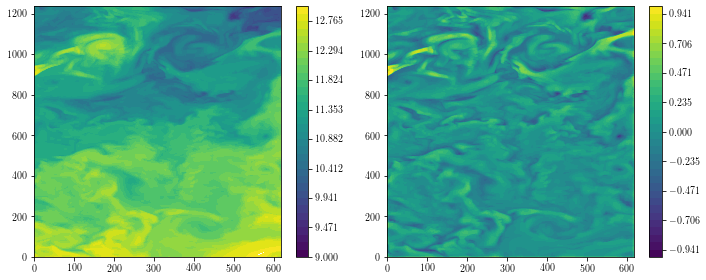

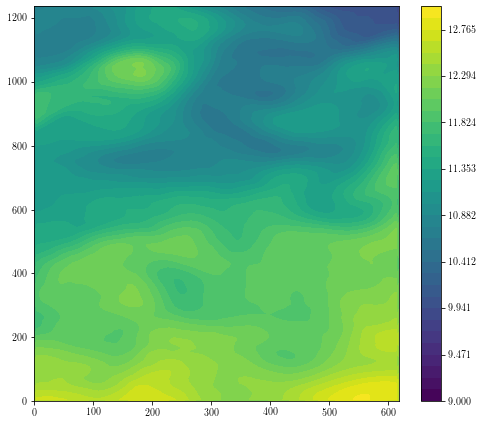

In [45]:
xlim=40


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(tf[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(9,13,35))
plt.colorbar()


plt.subplot(1,2,2)
plt.contourf(tf_band[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(-1,1,35))
plt.colorbar()

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/maps_filter_test_tophat.png')

plt.figure(figsize=(7,6))
plt.contourf(tf_low[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(9,13,35))
plt.colorbar()
plt.tight_layout()




In [46]:
xlim=4
sdec=1
asp=xrft.isotropic_power_spectrum(tf[::sdec,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),
                                  dim=['x_rho','y_rho'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(tf_band[:,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),
                                  dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

# csp=xrft.isotropic_power_spectrum(Qf[::dec,xlim:-xlim,xlim:-xlim].drop(['lat', 'lon']),
#                                   dim=['x','y'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
# dsp=xrft.isotropic_power_spectrum(hf_band[:,xlim:-xlim,xlim:-xlim].drop(['lat', 'lon']),
#                                   dim=['x','y'],nfactor=2,truncate='True',detrend='linear', window=True)



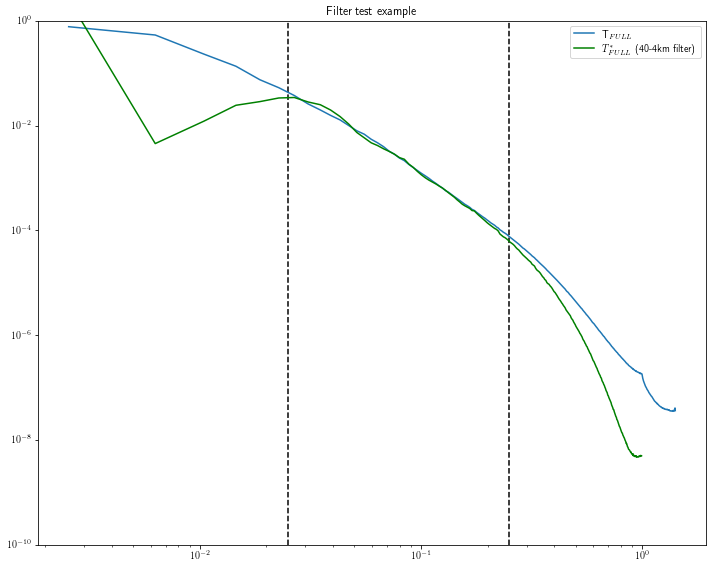

In [47]:

plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
plt.plot([1/4,1/4],[1e-12,1],'k--')


# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')
plt.plot(asp.freq_r/dxx,asp.mean(axis=0),label=r'T$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp.mean(axis=0),color='green',label=r'$T^*_{FULL}$ (40-4km filter)')




plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-10,1)
plt.tight_layout()



# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/filter_test_tophat.png')


In [48]:
# plt.figure(figsize=(10,8))
# plt.plot([1/40,1/40],[1e-12,1],'k--')
# plt.plot([1/4,1/4],[1e-12,1],'k--')


# # plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

# plt.title('Filter test example')
# plt.plot(csp.freq_r/dxx,asp.mean(axis=0),color='purple',label=r'HFX$_{FULL}$')
# plt.plot(dsp.freq_r/dxx,bsp.mean(axis=0),color='red',label=r'$HFX^*_{FULL}$ (40-4km filter)')




# plt.legend()

# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-10,1)
# plt.tight_layout()

In [49]:
ddec=10
reg_f=pd.DataFrame({'HFX':np.ravel(hf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],'SST':np.ravel(tf_band[:,xlim:-xlim,xlim:-xlim])[::ddec]})
# reg_fbar=pd.DataFrame({'HFX':np.ravel(h_fg)[::100],'SST':np.ravel(sst_fg)[::100]})
reg_low=pd.DataFrame({'HFX':np.ravel(hf_low[:,xlim:-xlim,xlim:-xlim])[::ddec],'SST':np.ravel(tf_low[:,xlim:-xlim,xlim:-xlim])[::ddec]})




In [50]:
Rsq=np.zeros([hf_band.shape[0]])*np.nan;
Rsq_low=np.zeros([hf_band.shape[0]])*np.nan;



for icc in range(Rsq.shape[0]):
    Rsq[icc]=np.corrcoef(np.ravel(hf_band[icc,xlim:-xlim,xlim:-xlim]),np.ravel(tf_band[icc,xlim:-xlim,xlim:-xlim]))[0][1]
    # Rsqm[icc]=np.corrcoef(np.ravel(r[icc]),np.ravel(h_fg[icc]))[0][1]
    Rsq_low[icc]=np.corrcoef(np.ravel(hf_low[icc,xlim:-xlim,xlim:-xlim]),np.ravel(tf_low[icc,xlim:-xlim,xlim:-xlim]))[0][1]



In [51]:
# np.corrcoef(reg_f.SST,reg_f.HFX)[0][1]
np.corrcoef(reg_low.SST,reg_low.HFX)[0][1]

0.11460845701486741

In [52]:
np.nanmean(Rsq)
np.nanmean(Rsq_low)

0.5165592015109575

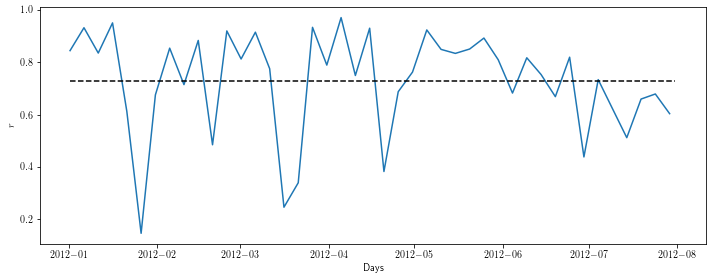

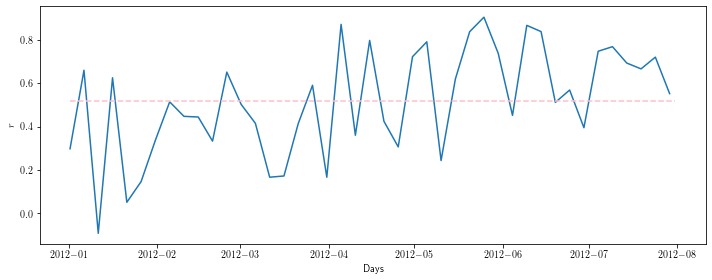

In [53]:
plt.figure(figsize=(10,4))

plt.plot(timer[::dec],Rsq)
plt.plot(timer,np.nanmean(Rsq)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r$')
plt.xlabel('Days')
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlation_timeseries_gauss.png')


plt.figure(figsize=(10,4))

plt.plot(timer[::dec],Rsq_low)
plt.plot(timer,np.nanmean(Rsq_low)+np.zeros(timer.shape),'k--',color='pink')
plt.ylabel(r'$r$')
plt.xlabel('Days')
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlation_timeseries_tophat.png')





In [54]:
apoly=np.zeros(hf_band.shape[0])*np.nan;
bpoly=np.zeros(hf_band.shape[0])*np.nan;
decx=20

for ide in range(hf_band.shape[0]):
    regg=pd.DataFrame({'HFX':np.ravel(hf_band[ide,xlim:-xlim,xlim:-xlim])[::decx],'SST':np.ravel(tf_band[ide,xlim:-xlim,xlim:-xlim])[::decx]})
    apoly[ide],bpoly[ide]=np.polyfit(regg.SST,regg.HFX,deg=1)


    
apoly_low=np.zeros(hf_band.shape[0])*np.nan;
bpoly_low=np.zeros(hf_band.shape[0])*np.nan;
for ide in range(hf_band.shape[0]):
    regg_low=pd.DataFrame({'HFX':np.ravel(hf_low[ide,xlim:-xlim,xlim:-xlim])[::decx],'SST':np.ravel(tf_low[ide,xlim:-xlim,xlim:-xlim])[::decx]})
    apoly_low[ide],bpoly_low[ide]=np.polyfit(regg_low.SST,regg_low.HFX,deg=1)




Text(0, 0.5, '$\\alpha$ $[W m^{-2}$ $^{\\circ}C$ $^{-1}]$')

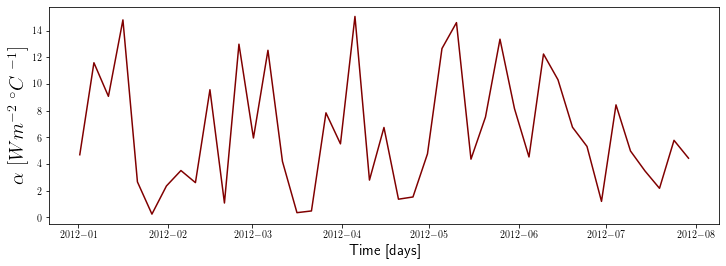

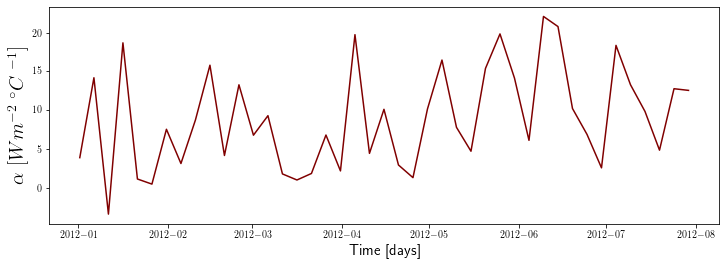

In [55]:
# dec=1
plt.figure(figsize=(12,4))
plt.plot(timer[::dec],apoly,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[W m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=20,fontweight='bold')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_timeseries_band_gauss.png')

plt.figure(figsize=(12,4))
plt.plot(timer[::dec],apoly_low,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[W m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=20,fontweight='bold')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_timeseries__lowf_gauss.png')
# 





In [56]:
np.nanmean(apoly)

6.396246492076327

In [57]:
aa,bb=np.polyfit(reg_f.SST,reg_f.HFX,deg=1)
aa_l,bb_l=np.polyfit(reg_low.SST,reg_low.HFX,deg=1)

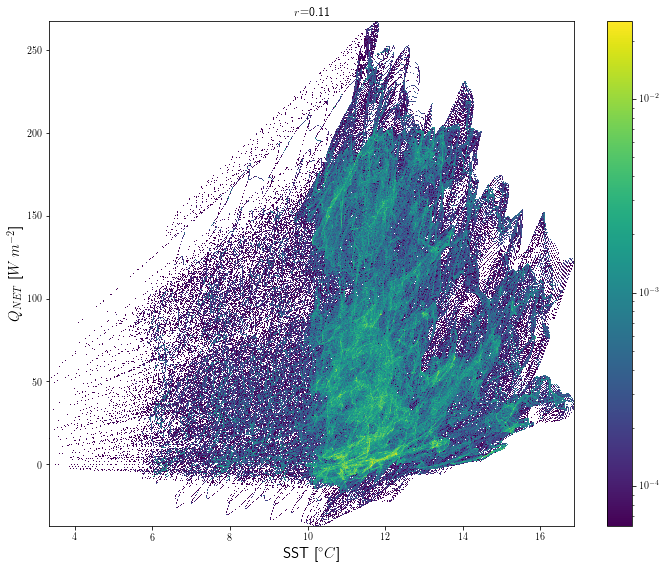

In [58]:
import matplotlib as mpl


plt.figure(figsize=(10,8))
plt.hist2d(reg_low.SST,reg_low.HFX,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
# plt.plot(reg_low.SST[::dec],(aa_l*reg_low.SST)[::dec],'w--',alpha=1)
# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(reg_low.SST,reg_low.HFX)[0][1]))
# plt.grid(color='w')



plt.colorbar()
plt.tight_layout()

In [59]:
aa

6.239761756849047

In [60]:
r'$r$'+'={0:.2f},'+'r$\alpha$'+'={1:.0f}'.format(np.corrcoef(reg_f.SST,reg_f.HFX)[0][1],
                                                           np.nanmean(apoly))

'$r$={0:.2f},r$\x07lpha$=6'

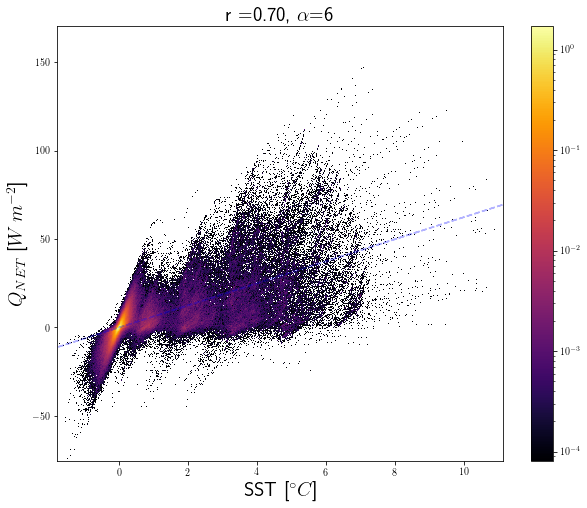

In [61]:
import matplotlib as mpl

rr=np.corrcoef(reg_f.SST,reg_f.HFX)[0][1]
am=np.nanmean(apoly)

plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.HFX,bins=1000,density=True,cmap='inferno',norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'b--',alpha=0.3)
# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'r ={0:.2f}, $\alpha$={1:.0f}'.format(rr,am),fontsize=20)
# plt.grid(color='w')
# plt.xlim(-0.5,0.5)
# plt.ylim(-15,15)


plt.colorbar()
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2d_histogram_gauss.png')
# # 


In [62]:
scales=[120,110,100,90,80,70,60,50,40,30,20,10]
corrs=np.zeros([len(scales)])

si=0
for scales_tmp in scales:

    tf_band=tophat_bandpass_2d(tf[:1],lowcut=scales_tmp,highcut=1)
    hf_band=tophat_bandpass_2d(hf[:1],lowcut=scales_tmp,highcut=1)

    xlim=int(np.round(scales_tmp))
    corrs[si]=np.corrcoef(np.ravel(tf_band[0,xlim:-xlim,xlim:-xlim]),np.ravel(hf_band[0,xlim:-xlim,xlim:-xlim]))[0][1]
    si+=1

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(scales,corrs,'o-')
plt.xlabel('Filter Scale [km]',fontsize=15,fontweight='bold')
plt.ylabel(r'$r^{2}$',fontsize=15,fontweight='bold')

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlations_vs_scales2.png')



## Filtering SST and wind to find the $\gamma$ coefficient

In [ ]:
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

# ust=vart.sustr.groupby("time_counter.dayofyear").mean()
# ust=ust.chunk(chunks=chunks_new);
# ust=ust.compute();


vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();

# vst=vart.svstr.groupby("time_counter.dayofyear").mean()
# vst=vst.chunk(chunks=chunks_new);
# vst=vst.compute();



usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
# ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
# ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [21]:
wsf=usf.copy()
wsf.data=np.sqrt(usf.data**2 + vsf.data**2)

In [23]:
dec=10
tf_band=tophat_bandpass_2d(tf[::dec],lowcut=45,highcut=1)
# tt_band=tophat_bandpass_2d(tt[::dec],lowcut=45,highcut=1)

wsf_band=tophat_bandpass_2d(wsf[::dec],lowcut=45,highcut=1)
# ht_band=tophat_bandpass_2d(ht[::dec],lowcut=45,highcut=1)




IOStream.flush timed out


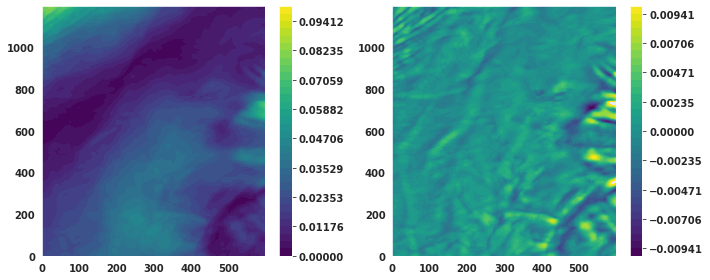

In [92]:
xlim=40


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(wsf[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(0,0.1,35))
plt.colorbar()


plt.subplot(1,2,2)
plt.contourf(wsf_band[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(-0.01,0.01,35))
plt.colorbar()

plt.tight_layout()

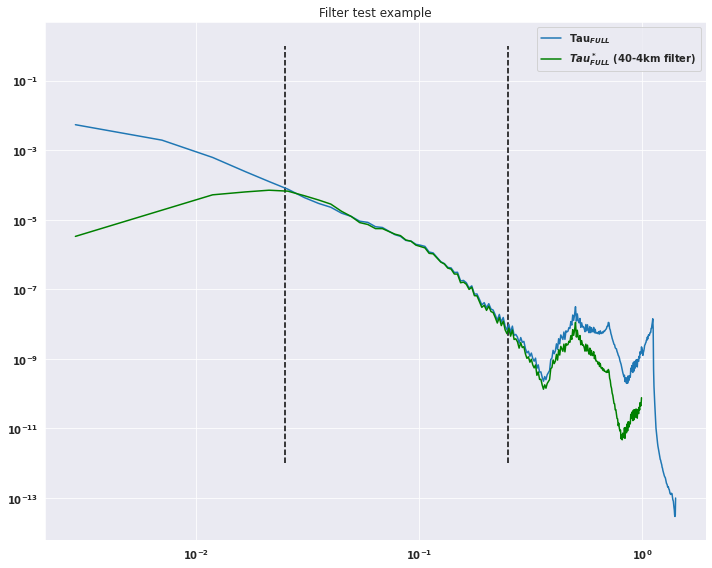

In [93]:
xlim=40
asp=xrft.isotropic_power_spectrum(wsf[::dec,xlim:-xlim,xlim:-xlim],dim=['x_u','y_u'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(wsf_band[:,xlim:-xlim,xlim:-xlim],dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)



plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
plt.plot([1/4,1/4],[1e-12,1],'k--')


# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')
plt.plot(asp.freq_r/dxx,asp.mean(axis=0),label=r'Tau$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp.mean(axis=0),color='green',label=r'$Tau^*_{FULL}$ (40-4km filter)')




plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.ylim(1e-10,1)
plt.tight_layout()

In [94]:
ddec=1
reg_f=pd.DataFrame({'SST':np.ravel(tf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],'Tau':np.ravel(wsf_band[:,xlim:-xlim,xlim:-xlim])[::ddec]})
# reg_fbar=pd.DataFrame({'HFX':np.ravel(h_fg)[::100],'SST':np.ravel(sst_fg)[::100]})




In [95]:
np.corrcoef(reg_f.SST,reg_f.Tau)

array([[1.        , 0.46675387],
       [0.46675387, 1.        ]])

In [96]:
Rsq=np.zeros([wsf_band.shape[0]])*np.nan;

for icc in range(Rsq.shape[0]):
    Rsq[icc]=np.corrcoef(np.ravel(tf_band[icc,xlim:-xlim,xlim:-xlim]),np.ravel(wsf_band[icc,xlim:-xlim,xlim:-xlim]))[0][1]
    # Rsqm[icc]=np.corrcoef(np.ravel(r[icc]),np.ravel(h_fg[icc]))[0][1]



In [97]:
np.corrcoef(reg_f.SST,reg_f.Tau)[0][1]

0.4667538669977552

In [98]:
np.nanmean(Rsq)

0.4565212541560371

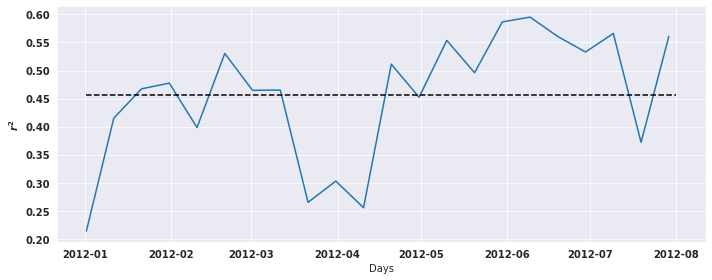

In [99]:
plt.figure(figsize=(10,4))

plt.plot(timer[::dec],Rsq)
plt.plot(timer,np.nanmean(Rsq)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlation_timeseries_SSTxWindstress_tophat.png')




In [100]:
apoly=np.zeros(wsf_band.shape[0])*np.nan;
bpoly=np.zeros(wsf_band.shape[0])*np.nan;
for ide in range(wsf_band.shape[0]):
    decx=1
    regg=pd.DataFrame({'SST':np.ravel(tf_band[ide,xlim:-xlim,xlim:-xlim])[::decx],'Tau':np.ravel(wsf_band[ide,xlim:-xlim,xlim:-xlim])[::decx]})
    apoly[ide],bpoly[ide]=np.polyfit(regg.SST,regg.Tau,deg=1)



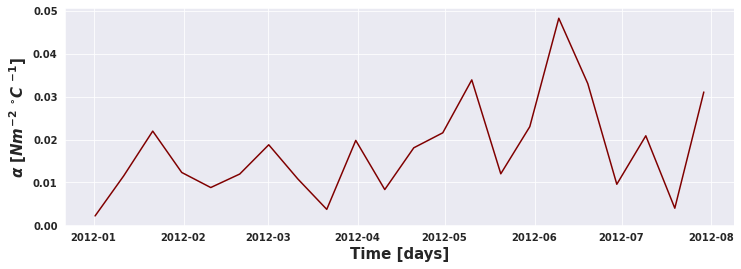

In [107]:

plt.figure(figsize=(12,4))
plt.plot(timer[::dec],apoly,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[N m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=15,fontweight='bold')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_timeseries_SSTxWindstress_tophat.png')





In [56]:
aa,bb=np.polyfit(reg_f.SST,reg_f.Tau,deg=1)

In [104]:
aa

0.009668664830090715

In [105]:
np.nanmean(apoly)

0.017529891469346512

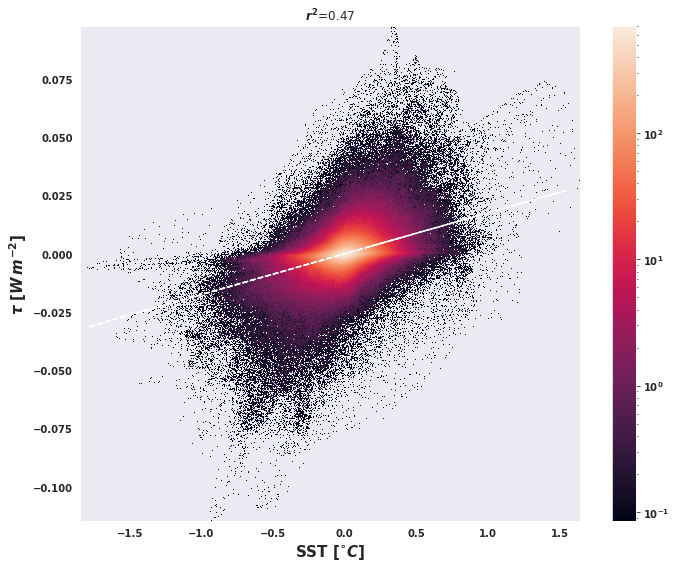

In [109]:
import matplotlib as mpl

plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.Tau,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
# plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'w--',alpha=1)
plt.plot(reg_f.SST[::dec],(np.nanmean(apoly)*reg_f.SST)[::dec],'w--',alpha=1)



# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\tau$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r^{2}$'+'={0:.2f}'.format(np.corrcoef(reg_f.SST,reg_f.Tau)[0][1]))
# plt.grid(color='w')



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2d_histogram_SSTxWindstress_tophat.png')
# 

